In [1]:
import tensorflow as tf
import PIL
import time

In [2]:
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint,TensorBoard

Using TensorFlow backend.


In [3]:
vgg_conv = VGG16(weights='imagenet',include_top=False,input_shape=(256, 256, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-3]:
    layer.trainable = False

In [5]:
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000024A363D6B38> False
<keras.layers.convolutional.Conv2D object at 0x0000024A363F7470> False
<keras.layers.convolutional.Conv2D object at 0x0000024A363F7390> False
<keras.layers.pooling.MaxPooling2D object at 0x0000024A36416978> False
<keras.layers.convolutional.Conv2D object at 0x0000024A36416D68> False
<keras.layers.convolutional.Conv2D object at 0x0000024A36461278> False
<keras.layers.pooling.MaxPooling2D object at 0x0000024A36475F28> False
<keras.layers.convolutional.Conv2D object at 0x0000024A364752E8> False
<keras.layers.convolutional.Conv2D object at 0x0000024A364A8518> False
<keras.layers.convolutional.Conv2D object at 0x0000024A364C4DA0> False
<keras.layers.pooling.MaxPooling2D object at 0x0000024A364F76D8> False
<keras.layers.convolutional.Conv2D object at 0x0000024A364F7BE0> False
<keras.layers.convolutional.Conv2D object at 0x0000024A36528828> False
<keras.layers.convolutional.Conv2D object at 0x0000024A36528320> False
<ker

In [6]:
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Dropout
# get layers and add average pooling layer

x = vgg_conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# add output layer
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=vgg_conv.input, outputs=predictions)
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
___________________________

In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_batchsize = 32
val_batchsize = 10
img_size=256
train_dir="data/peach/train"
val_dir="data/peach/val"

In [10]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=train_batchsize,
        class_mode='categorical',
        color_mode="rgb",
        shuffle=True
)

Found 2391 images belonging to 2 classes.


In [11]:
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(img_size, img_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        color_mode="rgb",
        shuffle=False)

Found 266 images belonging to 2 classes.


In [12]:
dic=train_generator.class_indices
dic

{'Peach___Bacterial_spot': 0, 'Peach___healthy': 1}

In [13]:
dic = {v: k for k, v in dic.items()}
dic

{0: 'Peach___Bacterial_spot', 1: 'Peach___healthy'}

In [14]:
import json

with open('weights/peach_label.json', 'w') as fp:
    json.dump(dic, fp)

In [15]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [16]:
checkpoint = ModelCheckpoint("weights/vgg16_best_peach.hdf5",monitor='val_acc',verbose=1,save_best_only=True,mode='max')

In [17]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      callbacks=[checkpoint],
      verbose=1)
model.save('weights/vgg16_peach.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
75/74 [==============================] - 72s 961ms/step - loss: 0.3732 - acc: 0.8613 - val_loss: 0.2682 - val_acc: 0.8647

Epoch 00001: val_acc improved from -inf to 0.86466, saving model to weights/vgg16_best_peach.hdf5
Epoch 2/10
75/74 [==============================] - 37s 492ms/step - loss: 0.2446 - acc: 0.8738 - val_loss: 0.1370 - val_acc: 0.9023

Epoch 00002: val_acc improved from 0.86466 to 0.90226, saving model to weights/vgg16_best_peach.hdf5
Epoch 3/10
75/74 [==============================] - 38s 508ms/step - loss: 0.1480 - acc: 0.9315 - val_loss: 0.0623 - val_acc: 0.9887

Epoch 00003: val_acc improved from 0.90226 to 0.98872, saving model to weights/vgg16_best_peach.hdf5
Epoch 4/10
75/74 [==============================] - 39s 520ms/step - loss: 0.0866 - acc: 0.9740 - val_loss: 0.0334 - val_acc: 0.9887

Epoch 00004: val_acc did not improve from 0.98872
Epoch 5/10
75/74 [==============================] - 38s 509ms/step

In [18]:
# serialize model to JSON
model_json = model.to_json()
with open("weights/VGG16_peach_model.json", "w") as json_file:
    json_file.write(model_json)

In [19]:
# Save the model
model.save('weights/vgg16_peach.h5')

## Visualising val_acc and train_acc curves

In [20]:
import matplotlib.pyplot as plt

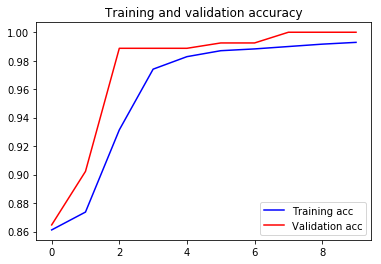

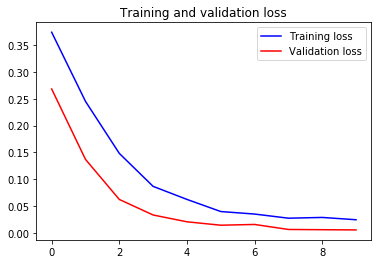

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### let us visually see the errors that we got.

In [22]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        "data/peach/val",
        target_size=(256, 256),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1) 


Found 266 images belonging to 2 classes.
27/26 [==============================] - 4s 155ms/step


In [23]:
import numpy as np
import PIL 
from keras.preprocessing import image

In [24]:
predicted_classes = np.argmax(predictions,axis=1)
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = image.load_img('{}/{}'.format("data/peach/val",fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

No of errors = 0/266


## Predict Output

In [ ]:
# load json and create model
from keras.models import model_from_json
json_file = open('weights/VGG16/VGG16_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("weights/VGG16/vgg16_best.hdf5")
print("Loaded model from disk")

In [ ]:
loaded_model.summary()

In [ ]:
import cv2
from tqdm import tqdm
import itertools
import numpy as np
import matplotlib.pyplot as plt
import json

In [ ]:
im = cv2.imread("test images/orange_han.jpg")

In [ ]:
im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256))
plt.imshow(im)
im = np.expand_dims(im, axis =0)
im=cv2.normalize(im.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

In [ ]:
loaded_model.predict(im)

In [ ]:
outcome=loaded_model.predict(im)

In [ ]:
sum(outcome[0])

In [ ]:
np.argmax(outcome)

In [ ]:
with open('labels.json', 'r') as fp:
    data = json.load(fp)

In [ ]:
data[str(np.argmax(outcome))]

In [ ]:
from keras.models import model_from_json
import cv2
import numpy as np
import json

# loading model from json
json_file = open('weights/VGG16/VGG16_model.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model.load_weights("weights/VGG16/vgg16_best.hdf5")
#print("Loaded model from disk")

# file path
im = cv2.imread("test images/tomato_healthy.JPG")
im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256))
im = np.expand_dims(im, axis =0)

outcome = model.predict(im)

# loading labels file to convert to string
with open('labels.json', 'r') as fp:
    data = json.load(fp)

pred_disease=data[str(np.argmax(outcome))]
print("predicted output:",pred_disease)